### Load data

In [1]:
from pickle import load

with open('../input/rainbow-store/data.pkl', 'rb') as file:
    data = load(file)

### Labels distribution

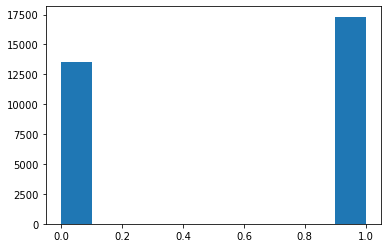

In [2]:
import matplotlib.pyplot as plt
plt.hist(data[1])
plt.show()

### Set up TPU

In [3]:
from tensorflow.distribute.cluster_resolver import TPUClusterResolver
from tensorflow.config import experimental_connect_to_cluster
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.distribute.experimental import TPUStrategy
from tensorflow.distribute import get_strategy

try:
    tpu = TPUClusterResolver()
    experimental_connect_to_cluster(tpu)
    initialize_tpu_system(tpu)
    strategy = TPUStrategy(tpu)
    print('using TPU...')
except ValueError:
    strategy = get_strategy() # for CPU and single GPU
    print('not using TPU...')

using TPU...


### Convert data to tf dataset

In [4]:
from tensorflow import data as d
from tensorflow.data.experimental import AUTOTUNE
from tensorflow import float32
from tensorflow.ragged import constant

batch_size = 16 * strategy.num_replicas_in_sync

predict = d.Dataset.from_tensor_slices(constant(data[2]).to_tensor()).batch(batch_size).prefetch(AUTOTUNE) # data for prediction
customers = data[3]
features = constant(data[0]).to_tensor() #padding
data = d.Dataset.from_tensor_slices((features, data[1])).shuffle(31000)

# train-val-test split
val = data.take(6000)
test = val.take(3000)
val = val.skip(3000)
data = data.skip(6000)

data = data.batch(batch_size).prefetch(AUTOTUNE)
val = val.batch(batch_size).prefetch(AUTOTUNE)
test = test.batch(batch_size).prefetch(AUTOTUNE)

### Build model

In [5]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import Precision, Recall

# with strategy.scope():
model = Sequential([LSTM(32, return_sequences=True, input_shape=(None, 41)), Dropout(0.2),LSTM(32, return_sequences=False), 
                    Dropout(0.2), Dense(16, activation='relu'), Dense(1, activation='sigmoid')])
model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          9472      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 18,337
Trainable params: 18,337
Non-trainable params: 0
____________________________________________________

### Train model

In [6]:
hst = model.fit(data, epochs=30, validation_data=val)

Epoch 1/30
194/194 [==============================] - 11s 58ms/step - loss: 0.5575 - accuracy: 0.7079 - precision: 0.7318 - recall: 0.7566 - val_loss: 0.5476 - val_accuracy: 0.7230 - val_precision: 0.7915 - val_recall: 0.6717
Epoch 2/30
194/194 [==============================] - 12s 62ms/step - loss: 0.5316 - accuracy: 0.7323 - precision: 0.7653 - recall: 0.7551 - val_loss: 0.5180 - val_accuracy: 0.7433 - val_precision: 0.7395 - val_recall: 0.8433
Epoch 3/30
194/194 [==============================] - 12s 64ms/step - loss: 0.5325 - accuracy: 0.7321 - precision: 0.7685 - recall: 0.7484 - val_loss: 0.5243 - val_accuracy: 0.7393 - val_precision: 0.8177 - val_recall: 0.6833
Epoch 4/30
194/194 [==============================] - 13s 66ms/step - loss: 0.5292 - accuracy: 0.7343 - precision: 0.7716 - recall: 0.7478 - val_loss: 0.5474 - val_accuracy: 0.7267 - val_precision: 0.7959 - val_recall: 0.6877
Epoch 5/30
194/194 [==============================] - 13s 66ms/step - loss: 0.5313 - accuracy: 0

In [7]:
def visualize(metric):
    plt.plot(hst.history[metric])
    plt.plot(hst.history['val_' + metric])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

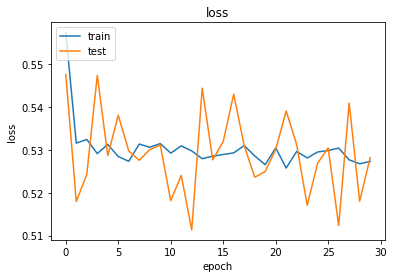

In [8]:
visualize('loss')

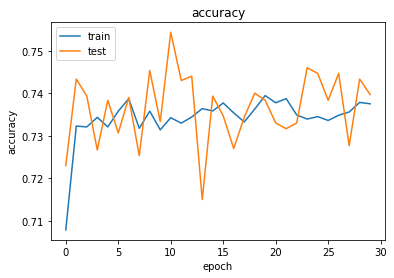

In [9]:
visualize('accuracy')

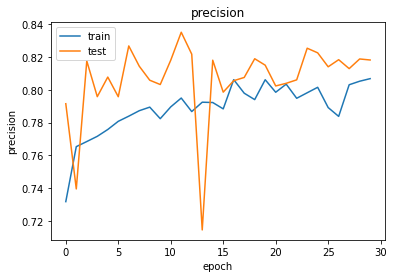

In [10]:
visualize('precision')

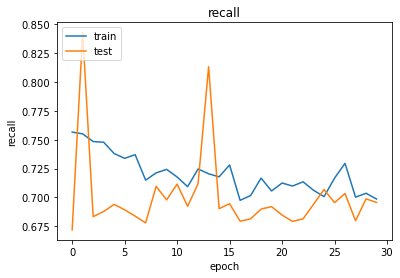

In [11]:
visualize('recall')

### Performance Evaluation

In [12]:
result = model.evaluate(test)
dict(zip(model.metrics_names, result))

24/24 [==============================] - 1s 22ms/step - loss: 0.5320 - accuracy: 0.7270 - precision: 0.7944 - recall: 0.6863


{'loss': 0.5320025086402893,
 'accuracy': 0.7269999980926514,
 'precision': 0.7944444417953491,
 'recall': 0.6862627267837524}

### Prediction

In [13]:
prediction = model.predict(predict)
with open('customers.txt', 'w') as file: 
    for index in range(len(customers)):
        if prediction[index] >= 0.5:
            file.write("%s\n" % customers[index])